# Data Scientist Nanodegree

## Capstone Project: Gendered Pronoun Resolution

### Pair pronouns to their correct entities

This is the capstone project for Udacity's Data Scientist Nanodegree. I will participate in the Kaggle competition: 
### Content

I will break the notebook into separate steps. 

* [Step 1](#step1):  Project Overview
* [Step 2](#step2): Problem Statement
* [Step 3](#step3): Metrics
* [Step 4](#step4): Data Exploration
* [Step 5](#step5): Data Visualization
* [Step 6](#step6): Data Preprocessing
* [Step 7](#step7): Implementation
* [Step 8](#step8): Model Evaluation and Validation
* [Step 9](#step9): Improvement


## Step 1: Project Overview
 
![avatar](https://storage.googleapis.com/kaggle-media/competitions/GoogleAI-GenderedPronoun/PronounResolution.png)
Pronoun resolution is part of coreference resolution, the task of pairing an expression to its referring entity. This is an important task for natural language understanding, and the resolution of ambiguous pronouns is a longstanding challenge.

Unfortunately, recent studies have suggested gender bias among state-of-the-art coreference resolvers. [Google AI Language](https://ai.google/research/teams/language/) aims to improve gender-fairness in modeling by releasing the [Gendered Ambiguous Pronouns (GAP) dataset](http://goo.gl/language/gap-coreference), containing gender-balanced pronouns (50% of its examples containing feminine pronouns, and 50% containing masculine pronouns).


## Step 2: Problem Statement
In this project, I will try the following to solve the problem: 
* 1. Use a pre-trained version for the Bert transformer model to obtain contextual word embeddings for the 3 target words in each passage: A, B and Pronoun.
* 2. Feed this into a multi-layer perceptron(MLP), which learns to solve the coreference resolution problem as a supervised classification task. 

The idea comes from the [paper](https://openreview.net/pdf?id=SJzSgnRcKX) "What do you learn from context? Probing for sentence structure in contextualized word representations" by Tenney et al. For coreference resolution, they use the OntoNotes and Definite Pronoun Resolution datasets, but not GAP. As such, the MLP hyperparameters they use may not be the best for our current task. The hyperparameters I use below are quite different from theirs.

They are three GAP files available.
The gap-development file contains the same data as the test_stage_1 file that we're trying to make predictions on. Of course, gap-development also contains the true labels, but I'm not using these when making predictions. I only use the true labels to evaluate the predictions made by my model. The other two files, gap-test and gap-validation, are used for training the model.

## Step 3: Metrics

Results are evaluated using the multi-class logarithmic loss. Each pronoun has been labeled with whether it refers to A, B, or NEITHER. For each pronoun, a set of predicted probabilities (one for each class) must be submitted. The formula is then,

![avatar](http://s8.picofile.com/file/8351608076/1.png)
where N is the number of samples in the test set, M is 3,  log is the natural logarithm, yij is 1 if observation i belongs to class j and 0 otherwise, and pij is the predicted probability that observation i belongs to class j.

## Step 4: Data Exploration
The test_stage_1.tsv data contains the same 2000 rows as gap-development.tsv data and we will explore it.

In [28]:
import numpy as np 
import pandas as pd 

# Input data files are available in the "../input/" directory.

import os
print(os.listdir("../input"))
import zipfile
import sys
import time

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile

['test_stage_1.tsv', 'sample_submission_stage_1.csv']


In [29]:
# read dataset
gendered_pronoun_df = pd.read_csv('../input/test_stage_1.tsv', delimiter='\t')
submission = pd.read_csv('../input/sample_submission_stage_1.csv')

In [30]:
gendered_pronoun_df.shape

(2000, 9)

In [31]:
submission.head()

,ID,A,B,NEITHER
0,development-1,0.33333,0.33333,0.33333
1,development-2,0.33333,0.33333,0.33333
2,development-3,0.33333,0.33333,0.33333
3,development-4,0.33333,0.33333,0.33333
4,development-5,0.33333,0.33333,0.33333


In [32]:
gendered_pronoun_df.head(5)

,ID,Text,Pronoun,Pronoun-offset,A,A-offset,B,B-offset,URL
0,development-1,Zoe Telford -- played the police officer girlf...,her,274,Cheryl Cassidy,191,Pauline,207,http://en.wikipedia.org/wiki/List_of_Teachers_...
1,development-2,"He grew up in Evanston, Illinois the second ol...",His,284,MacKenzie,228,Bernard Leach,251,http://en.wikipedia.org/wiki/Warren_MacKenzie
2,development-3,"He had been reelected to Congress, but resigne...",his,265,Angeloz,173,De la Sota,246,http://en.wikipedia.org/wiki/Jos%C3%A9_Manuel_...
3,development-4,The current members of Crime have also perform...,his,321,Hell,174,Henry Rosenthal,336,http://en.wikipedia.org/wiki/Crime_(band)
4,development-5,Her Santa Fe Opera debut in 2005 was as Nuria ...,She,437,Kitty Oppenheimer,219,Rivera,294,http://en.wikipedia.org/wiki/Jessica_Rivera


In [33]:
gendered_pronoun_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
ID                2000 non-null object
Text              2000 non-null object
Pronoun           2000 non-null object
Pronoun-offset    2000 non-null int64
A                 2000 non-null object
A-offset          2000 non-null int64
B                 2000 non-null object
B-offset          2000 non-null int64
URL               2000 non-null object
dtypes: int64(3), object(6)
memory usage: 140.7+ KB


**Variables**
1. ID - Unique identifier for an example (Matches to Id in output file format)
2. Text - Text containing the ambiguous pronoun and two candidate names (about a paragraph in length)
3. Pronoun - The target pronoun (text)
4. Pronoun-offset The character offset of Pronoun in Text
5. A - The first name candidate (text)
6. A-offset - The character offset of name A in Text
7. B - The second name candidate
8. B-offset - The character offset of name B in Text
9. URL - The URL of the source Wikipedia page for the example**

## Step 5: Data Visulization

In [34]:
from wordcloud import WordCloud as wc
from nltk.corpus import stopwords
def generate_wordcloud(text):
    wordcloud = wc(relative_scaling=1.0, stopwords=eng_stopwords).generate(text)
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.margins(x=0, y=0)
    plt.show()

In [35]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

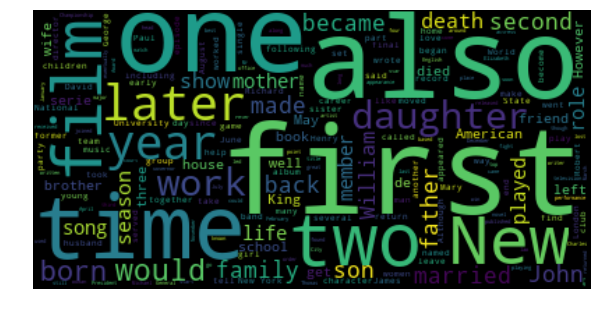

In [36]:
eng_stopwords = set(stopwords.words("english"))
text = ''.join(gendered_pronoun_df.Text)
generate_wordcloud(text)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3aa5b3c278>,
      dtype=object)

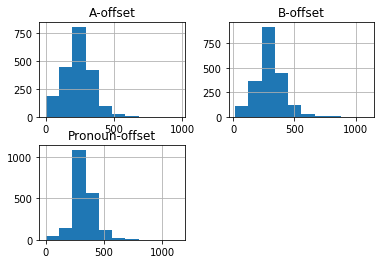

In [37]:
gendered_pronoun_df.hist()

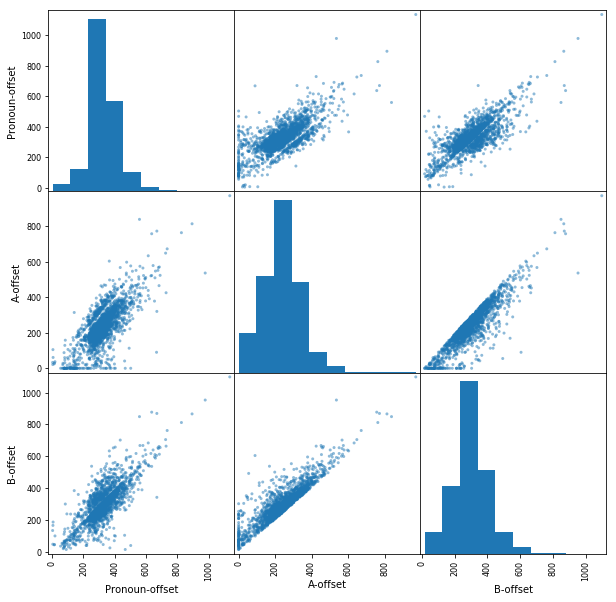

<Figure size 432x288 with 0 Axes>

In [38]:
pd.plotting.scatter_matrix(gendered_pronoun_df,figsize=(10,10))
plt.figure();

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


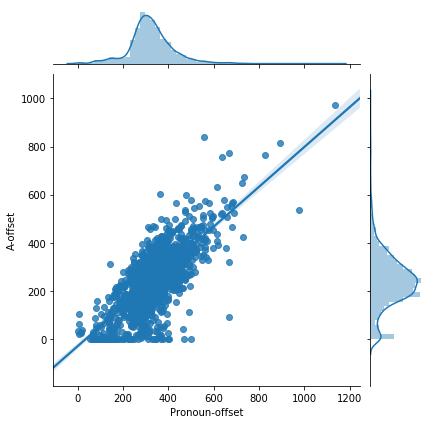

In [39]:
sns.jointplot(x='Pronoun-offset',y='A-offset' ,data=gendered_pronoun_df, kind='reg')

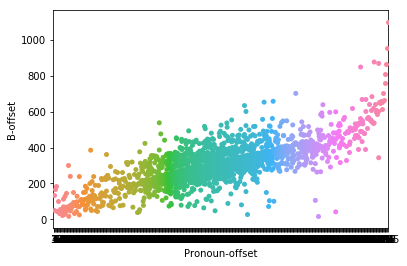

In [40]:
sns.swarmplot(x='Pronoun-offset',y='B-offset',data=gendered_pronoun_df);

## Step 6: Data Preprocessing
First download the pre-trained BERT -Base, Uncased model. 

In [41]:
#downloading weights and cofiguration file for the model
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
with zipfile.ZipFile("uncased_L-12_H-768_A-12.zip","r") as zip_ref:
    zip_ref.extractall()
!ls 'uncased_L-12_H-768_A-12'

--2019-03-26 13:29:13--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 2607:f8b0:400c:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip.1’

uncased_L-12_H-768_ 100%[===================>] 388.84M   157MB/s    in 2.5s    

2019-03-26 13:29:15 (157 MB/s) - ‘uncased_L-12_H-768_A-12.zip.1’ saved [407727028/407727028]

bert_config.json		     bert_model.ckpt.index  vocab.txt
bert_model.ckpt.data-00000-of-00001  bert_model.ckpt.meta


Next, in order to feed our data to the model, we'll use some scripts from the bert repo on GitHub.

In [42]:
!wget https://raw.githubusercontent.com/google-research/bert/master/modeling.py 
!wget https://raw.githubusercontent.com/google-research/bert/master/extract_features.py 
!wget https://raw.githubusercontent.com/google-research/bert/master/tokenization.py

--2019-03-26 13:29:26--  https://raw.githubusercontent.com/google-research/bert/master/modeling.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37922 (37K) [text/plain]
Saving to: ‘modeling.py.1’

modeling.py.1       100%[===================>]  37.03K  --.-KB/s    in 0.01s   

2019-03-26 13:29:26 (2.93 MB/s) - ‘modeling.py.1’ saved [37922/37922]

--2019-03-26 13:29:26--  https://raw.githubusercontent.com/google-research/bert/master/extract_features.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13898 (14K) [text/plain]
Saving to: ‘ex

In [43]:
import modeling
import extract_features
import tokenization
import tensorflow as tf

Finally, download all the data from the GAP repo. The gap-development.tsv data contains the same 2000 rows as test_stage_1.tsv data. So we'll make predictions on it. The other two files, gap-validation.tsv with 454 rows, and gap-test.tsv with 2000 rows, will be used for training.

In [44]:
!wget https://raw.githubusercontent.com/google-research-datasets/gap-coreference/master/gap-development.tsv
!wget https://raw.githubusercontent.com/google-research-datasets/gap-coreference/master/gap-validation.tsv
!wget https://raw.githubusercontent.com/google-research-datasets/gap-coreference/master/gap-test.tsv
!ls

--2019-03-26 13:29:47--  https://raw.githubusercontent.com/google-research-datasets/gap-coreference/master/gap-development.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1080993 (1.0M) [text/plain]
Saving to: ‘gap-development.tsv.1’

gap-development.tsv 100%[===================>]   1.03M  --.-KB/s    in 0.07s   

2019-03-26 13:29:47 (14.1 MB/s) - ‘gap-development.tsv.1’ saved [1080993/1080993]

--2019-03-26 13:29:47--  https://raw.githubusercontent.com/google-research-datasets/gap-coreference/master/gap-validation.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, await

Then, we feed BERT the data from these three files. For each line, we want to obtain contextual embeddings for the 3 target words (A, B, Pronoun). Here are some helper functions to keep track of the offsets of the target words.

In [45]:
def compute_offset_no_spaces(text, offset):
    count = 0
    for pos in range(offset):
        if text[pos] != " ": count +=1
    return count

def count_chars_no_special(text):
    count = 0
    special_char_list = ["#"]
    for pos in range(len(text)):
        if text[pos] not in special_char_list: count +=1
    return count

def count_length_no_special(text):
    count = 0
    special_char_list = ["#", " "]
    for pos in range(len(text)):
        if text[pos] not in special_char_list: count +=1
    return count

The following method takes the data from a file, passes it through BERT to obtain contextual embeddings for the target words, then returns these embeddings in the emb DataFrame. Below, we will use it 3 times, once for each of the files gap-test, gap-development, gap-validation.

In [46]:
def run_bert(data):
    '''
    Runs a forward propagation of BERT on input text, extracting contextual word embeddings
    Input: data, a pandas DataFrame containing the information in one of the GAP files

    Output: emb, a pandas DataFrame containing contextual embeddings for the words A, B and Pronoun. Each embedding is a numpy array of shape (768)
    columns: "emb_A": the embedding for word A
             "emb_B": the embedding for word B
             "emb_P": the embedding for the pronoun
             "label": the answer to the coreference problem: "A", "B" or "NEITHER"
    '''
    # From the current file, take the text only, and write it in a file which will be passed to BERT
    text = data["Text"]
    text.to_csv("input.txt", index = False, header = False)

    # The script extract_features.py runs forward propagation through BERT, and writes the output in the file output.jsonl
    # I'm lazy, so I'm only saving the output of the last layer. Feel free to change --layers = -1 to save the output of other layers.
    os.system("python3 extract_features.py \
      --input_file=input.txt \
      --output_file=output.jsonl \
      --vocab_file=uncased_L-12_H-768_A-12/vocab.txt \
      --bert_config_file=uncased_L-12_H-768_A-12/bert_config.json \
      --init_checkpoint=uncased_L-12_H-768_A-12/bert_model.ckpt \
      --layers=-1 \
      --max_seq_length=256 \
      --batch_size=8")

    bert_output = pd.read_json("output.jsonl", lines = True)

    os.system("rm output.jsonl")
    os.system("rm input.txt")

    index = data.index
    columns = ["emb_A", "emb_B", "emb_P", "label"]
    emb = pd.DataFrame(index = index, columns = columns)
    emb.index.name = "ID"

    for i in range(len(data)): # For each line in the data file
        # get the words A, B, Pronoun. Convert them to lower case, since we're using the uncased version of BERT
        P = data.loc[i,"Pronoun"].lower()
        A = data.loc[i,"A"].lower()
        B = data.loc[i,"B"].lower()

        # For each word, find the offset not counting spaces. This is necessary for comparison with the output of BERT
        P_offset = compute_offset_no_spaces(data.loc[i,"Text"], data.loc[i,"Pronoun-offset"])
        A_offset = compute_offset_no_spaces(data.loc[i,"Text"], data.loc[i,"A-offset"])
        B_offset = compute_offset_no_spaces(data.loc[i,"Text"], data.loc[i,"B-offset"])
        # Figure out the length of A, B, not counting spaces or special characters
        A_length = count_length_no_special(A)
        B_length = count_length_no_special(B)

        # Initialize embeddings with zeros
        emb_A = np.zeros(768)
        emb_B = np.zeros(768)
        emb_P = np.zeros(768)

        # Initialize counts
        count_chars = 0
        cnt_A, cnt_B, cnt_P = 0, 0, 0

        features = pd.DataFrame(bert_output.loc[i,"features"]) # Get the BERT embeddings for the current line in the data file
        for j in range(2,len(features)):  # Iterate over the BERT tokens for the current line; we skip over the first 2 tokens, which don't correspond to words
            token = features.loc[j,"token"]

            # See if the character count until the current token matches the offset of any of the 3 target words
            if count_chars  == P_offset: 
                # print(token)
                emb_P += np.array(features.loc[j,"layers"][0]['values'])
                cnt_P += 1
            if count_chars in range(A_offset, A_offset + A_length): 
                # print(token)
                emb_A += np.array(features.loc[j,"layers"][0]['values'])
                cnt_A +=1
            if count_chars in range(B_offset, B_offset + B_length): 
                # print(token)
                emb_B += np.array(features.loc[j,"layers"][0]['values'])
                cnt_B +=1
            # Update the character count
            count_chars += count_length_no_special(token)
        # Taking the average between tokens in the span of A or B, so divide the current value by the count	
        emb_A /= cnt_A
        emb_B /= cnt_B

        # Work out the label of the current piece of text
        label = "Neither"
        if (data.loc[i,"A-coref"] == True):
            label = "A"
        if (data.loc[i,"B-coref"] == True):
            label = "B"

        # Put everything together in emb
        emb.iloc[i] = [emb_A, emb_B, emb_P, label]

    return emb

Read the three GAP files, pass them through BERT, and write the contextual embeddings in json files. Unfortunately, I wasn't able to silence TensorFlow, so it's giving a lot of information and warnings when I run this cell.

In [47]:
print("Started at ", time.ctime())
test_data = pd.read_csv("gap-test.tsv", sep = '\t')
test_emb = run_bert(test_data)
test_emb.to_json("contextual_embeddings_gap_test.json", orient = 'columns')

validation_data = pd.read_csv("gap-validation.tsv", sep = '\t')
validation_emb = run_bert(validation_data)
validation_emb.to_json("contextual_embeddings_gap_validation.json", orient = 'columns')

development_data = pd.read_csv("gap-development.tsv", sep = '\t')
development_emb = run_bert(development_data)
development_emb.to_json("contextual_embeddings_gap_development.json", orient = 'columns')
print("Finished at ", time.ctime())

Started at  Tue Mar 26 13:31:16 2019


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide


Finished at  Tue Mar 26 13:42:18 2019


## Step 6: Implementation
Now that we have the embeddings, we pass them to a multi-layer perceptron (i.e. vanilla neural network), which learns to classify the triples of embeddings (emb_A, emb_B,emb_P) as "A", "B" or "NEITHER".

In [48]:
from keras import backend, models, layers, initializers, regularizers, constraints, optimizers
from keras import callbacks as kc
from keras import optimizers as ko

from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import log_loss
import time


dense_layer_sizes = [37]
dropout_rate = 0.6
learning_rate = 0.001
n_fold = 5
batch_size = 32
epochs = 1000
patience = 100
# n_test = 100
lambd = 0.1 # L2 regularization

Using TensorFlow backend.


We define a model with one hidden layers and one output layer in Keras.

In [1]:
def build_mlp_model(input_shape):
    X_input = layers.Input(input_shape)

    # Dense layer
    X = layers.Dense(dense_layer_sizes[0], name = 'dense0')(X_input)
    X = layers.BatchNormalization(name = 'bn0')(X)
    X = layers.Activation('relu')(X)
    X = layers.Dropout(dropout_rate, seed = 7)(X)

    # Output layer
    X = layers.Dense(3, name = 'output', kernel_regularizer = regularizers.l2(lambd))(X)
    X = layers.Activation('softmax')(X)

    # Create model
    model = models.Model(input = X_input, output = X, name = "classif_model")
    return model

In [50]:
def parse_json(embeddings):
    '''
    Parses the embeddigns given by BERT, and suitably formats them to be passed to the MLP model

    Input: embeddings, a DataFrame containing contextual embeddings from BERT, as well as the labels for the classification problem
    columns: "emb_A": contextual embedding for the word A
             "emb_B": contextual embedding for the word B
             "emb_P": contextual embedding for the pronoun
             "label": the answer to the coreference problem: "A", "B" or "NEITHER"

    Output: X, a numpy array containing, for each line in the GAP file, the concatenation of the embeddings of the target words
            Y, a numpy array containing, for each line in the GAP file, the one-hot encoded answer to the coreference problem
    '''
    embeddings.sort_index(inplace = True) # Sorting the DataFrame, because reading from the json file messed with the order
    X = np.zeros((len(embeddings),3*768))
    Y = np.zeros((len(embeddings), 3))

    # Concatenate features
    for i in range(len(embeddings)):
        A = np.array(embeddings.loc[i,"emb_A"])
        B = np.array(embeddings.loc[i,"emb_B"])
        P = np.array(embeddings.loc[i,"emb_P"])
        X[i] = np.concatenate((A,B,P))

    # One-hot encoding for labels
    for i in range(len(embeddings)):
        label = embeddings.loc[i,"label"]
        if label == "A":
            Y[i,0] = 1
        elif label == "B":
            Y[i,1] = 1
        else:
            Y[i,2] = 1

    return X, Y

We use the method defined above to parse the contextual embeddings, for each of the 3 GAP data files. The variable names here may be a bit counter-intuitive. Keep in mind that we will use X_test and X_validation for training, and then make predictions on X_development.

In [51]:
# Read development embeddigns from json file - this is the output of Bert
development = pd.read_json("contextual_embeddings_gap_development.json")
X_development, Y_development = parse_json(development)

validation = pd.read_json("contextual_embeddings_gap_validation.json")
X_validation, Y_validation = parse_json(validation)

test = pd.read_json("contextual_embeddings_gap_test.json")
X_test, Y_test = parse_json(test)

In [56]:
# There may be a few NaN values, where the offset of a target word is greater than the max_seq_length of BERT.
# They are very few, so I'm just dropping the rows.
remove_test = [row for row in range(len(X_test)) if np.sum(np.isnan(X_test[row]))]
X_test = np.delete(X_test, remove_test, 0)
Y_test = np.delete(Y_test, remove_test, 0)

remove_validation = [row for row in range(len(X_validation)) if np.sum(np.isnan(X_validation[row]))]
X_validation = np.delete(X_validation, remove_validation, 0)
Y_validation = np.delete(Y_validation, remove_validation, 0)

# We want predictions for all development rows. So instead of removing rows, make them 0
remove_development = [row for row in range(len(X_development)) if np.sum(np.isnan(X_development[row]))]
X_development[remove_development] = np.zeros(3*768)

In [57]:
# Will train on data from the gap-test and gap-validation files, in total 2454 rows
X_train = np.concatenate((X_test, X_validation), axis = 0)
Y_train = np.concatenate((Y_test, Y_validation), axis = 0)

# Will predict probabilities for data from the gap-development file; initializing the predictions
prediction = np.zeros((len(X_development),3)) # testing predictions

## Step 8: Model Evaluation and Validation


In [58]:
# Training and cross-validation
folds = KFold(n_splits=n_fold, shuffle=True, random_state=3)
scores = []
for fold_n, (train_index, valid_index) in enumerate(folds.split(X_train)):
    # split training and validation data
    print('Fold', fold_n, 'started at', time.ctime())
    X_tr, X_val = X_train[train_index], X_train[valid_index]
    Y_tr, Y_val = Y_train[train_index], Y_train[valid_index]

    # Define the model, re-initializing for each fold
    classif_model = build_mlp_model([X_train.shape[1]])
    classif_model.compile(optimizer = optimizers.Adam(lr = learning_rate), loss = "categorical_crossentropy")
    callbacks = [kc.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights = True)]

    # train the model
    classif_model.fit(x = X_tr, y = Y_tr, epochs = epochs, batch_size = batch_size, callbacks = callbacks, validation_data = (X_val, Y_val), verbose = 0)

    # make predictions on validation and test data
    pred_valid = classif_model.predict(x = X_val, verbose = 0)
    pred = classif_model.predict(x = X_development, verbose = 0)

    # oof[valid_index] = pred_valid.reshape(-1,)
    scores.append(log_loss(Y_val, pred_valid))
    prediction += pred
prediction /= n_fold

# Print CV scores, as well as score on the test data
print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
print(scores)
print("Test score:", log_loss(Y_development,prediction))

Fold 0 started at Tue Mar 26 13:49:25 2019
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="classif_model", inputs=Tensor("in..., outputs=Tensor("ac...)`


Fold 1 started at Tue Mar 26 13:50:09 2019


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="classif_model", inputs=Tensor("in..., outputs=Tensor("ac...)`


Fold 2 started at Tue Mar 26 13:50:52 2019


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="classif_model", inputs=Tensor("in..., outputs=Tensor("ac...)`


Fold 3 started at Tue Mar 26 13:51:34 2019


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="classif_model", inputs=Tensor("in..., outputs=Tensor("ac...)`


Fold 4 started at Tue Mar 26 13:52:17 2019


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="classif_model", inputs=Tensor("in..., outputs=Tensor("ac...)`


CV mean score: 0.5709, std: 0.0204.
[0.5740732934993128, 0.5433610927812895, 0.5979414291081423, 0.5863978358600954, 0.5525288900516675]
Test score: 0.52842775358817


## Step 9: Improvement

The best LB score I got with this method is 0.52. There are many things to try that could improve this, and I may attempt some of these in the future:
1. Fine-tune the BERT model, instead of using the pre-trained weights.
2. Use a mix of the BERT layers, instead of just the output of the last layer.
3. Tune some of the hyperparameters of the MLP model; I haven't played with them at all.
4. Look at all occurences of the target words A and B in the text, instead of just the one specified by the offset.
5. Extrace distance features in the preprocessing steps.